# Модель классификации в банковском скоринге

### Инициализация проекта. Стэк

In [2]:
!pip install pandas scikit-learn seaborn matplotlib numpy # Заглушка


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [98]:
df_train = pd.read_csv('datasets/train.csv', low_memory=False)
df_test = pd.read_csv('datasets/test.csv')

### Train и Test
#### Описание по столбцам:
> __ID__ - Представляет собой уникальную идентификацию записи

> __Customer_ID__ - Представляет собой уникальную идентификацию человека. *Потенциально полезен, но в производстве, потому что один человек имеет несколько записей в датасете*

> __Month__ - Обозначает месяц в году

> __Name__ - Имя человека

> __Age__ - Возраст человека

> __SSN__ - Представляет собой номер социального страхования человека

> __Occupation__ - Отражает род занятий этого человека

> __Annual_Income__ - Представляет собой годовой доход данного лица

> __Monthly_Inhand_Salary__ - Представляет собой месячную базовую заработную плату сотрудника

> __Num_Bank_Accounts__ - Представляет собой количество банковских счетов, которыми владеет человек

> __Num_Credit_Card__ - Представляет собой количество других кредитных карт, имеющихся у данного лица

> __Interest_Rate__ - Представляет собой процентную ставку по кредитной карте

> __Num_of_Loan__ - Представляет собой количество кредитов, взятых в банке

> __Type_of_Loan__ - Представляет виды займов, взятых человеком

> __Delay_from_due_date__ - Представляет собой среднее количество дней задержки с даты платежа

> __Num_of_Delayed_Payment__ - Представляет собой среднее количество платежей, задержанных одним лицом

> __Changed_Credit_Limit__ - Представляет собой процентное изменение лимита кредитной карты

> __Num_Credit_Inquiries__ - Представляет собой количество запросов по кредитным картам

> __Credit_Mix__ - Представляет собой классификацию набора кредитов

> __Outstanding_Debt__ - Представляет собой оставшуюся задолженность, подлежащую выплате (в долларах США).

> __Credit_Utilization_Ratio__ - Представляет собой коэффициент использования кредитной карты

> __Credit_History_Age__ - Отражает возраст кредитной истории данного лица

> __Payment_of_Min_Amount__ - Отражает, была ли выплачена лицом только минимальная сумма

> __Total_EMI_per_month__ - Представляет собой ежемесячные платежи EMI (в долларах США).

> __Amount_invested_monthly__ - Представляет собой ежемесячную сумму, инвестированную клиентом (в долларах США).

> __Payment_Behaviour__ - Отражает платежное поведение клиента (в долларах США).

> __Monthly_Balance__ - Представляет собой сумму ежемесячного баланса клиента (в долларах США).

> __Credit_Score__ - Представляет собой шкалу кредитного рейтинга (Poor, Standart, Good). Отсутствует в Test.csv
    

In [ ]:
# Пересечение
common_customers = set(df_train['Customer_ID']).intersection(set(df_test['Customer_ID']))
print(f"Количество клиентов, встречающихся и в train, и в test: {len(common_customers)}")


print("Примеры общих Customer_ID:", list(common_customers)[:5])

In [ ]:
# Проверим, сколько клиентов встречается и в train, и в test
common_customers = set(df_train['Customer_ID']).intersection(set(df_test['Customer_ID']))
print(f"Общих клиентов: {len(common_customers)}")

test_common_rows = df_test[df_test['Customer_ID'].isin(common_customers)]
print(f"Строк в test, относящихся к общим клиентам: {len(test_common_rows)}")

In [99]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (100000, 28)
Test shape: (50000, 27)


In [100]:
df_train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


#### Видим, что данные в датасете "грязные" - есть пропуски, поэтому и пришлось использовать low_memory

In [101]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

#### Делаем анализ и понимаем, что некоторые колонки являются мусорными
 К тому же есть много пропусков, что сильно портит наш датасет, ведь нам нужны числовые данные, а из-за пропусков получается object

### Pre-processing 1

In [102]:
# Удаляем лишние не имеющие силы Предикта колонки

drop_cols = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [103]:
# Сделаем числовые значения great again, в смысле, снова числовыми, а не object

num_cols = [
    'Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
    'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'
]

for col in num_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce') # Благодаря coerce разделяем записи на НАШИХ и "неправильно мыслящих", все должны мыслить числами!
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

In [104]:
# Преобразуем значения в колонке Credit_History_Age, там текстовые значения, а нам нужны по месяцам, чтобы были числовые данные и стало проще построить модель

def convert_credit_history(age_str):
    if pd.isna(age_str):
        return np.nan
    years = int(age_str.split()[0])
    months = int(age_str.split()[3])
    return years * 12 + months

df_train['Credit_History_Age'] = df_train['Credit_History_Age'].apply(convert_credit_history)
df_test['Credit_History_Age'] = df_test['Credit_History_Age'].apply(convert_credit_history)

После такого плотного преобразования смотрим результат

In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       95061 non-null   float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             93020 non-null   float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               95215 non-null   float64
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    90254 non-null   float64
 11  Changed_Credit_Limit      97909 non-null   float64
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

#### Видим, что как-то странно получается Age 

In [107]:
# Удалим МЕГАааа, значения: <18 или >109
valid_age = (df_train['Age'] >= 18) & (df_train['Age'] <= 109) # Под старость лет дед купил танк в кредит и отомстил соседу за украденные 20 см участка
df_train.loc[~valid_age, 'Age'] = np.nan

valid_age_test = (df_test['Age'] >= 18) & (df_test['Age'] <= 109)
df_test.loc[~valid_age_test, 'Age'] = np.nan

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       86939 non-null   float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             93020 non-null   float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               95215 non-null   float64
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    90254 non-null   float64
 11  Changed_Credit_Limit      97909 non-null   float64
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

In [109]:
df_train

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23.0,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,NaN,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,23.0,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25.0,Mechanic,39628.99,3359.415833,4,6,7,2.0,"Auto Loan, and Student Loan",23,...,_,502.38,34.663572,378.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
99996,25.0,Mechanic,39628.99,3359.415833,4,6,7,2.0,"Auto Loan, and Student Loan",18,...,_,502.38,40.565631,379.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
99997,25.0,Mechanic,39628.99,3359.415833,4,6,5729,2.0,"Auto Loan, and Student Loan",27,...,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,25.0,Mechanic,39628.99,3359.415833,4,6,7,2.0,"Auto Loan, and Student Loan",20,...,Good,502.38,33.638208,381.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


Видим  -1 в Delay_from_due_date

In [110]:
print("Уникальные значения Payment_Behaviour:")
print(df_train['Payment_Behaviour'].value_counts().head(10))

Уникальные значения Payment_Behaviour:
Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64


In [111]:
# Заменяем в обоих датасетах
df_train['Payment_Behaviour'] = df_train['Payment_Behaviour'].replace('!@9#%8', np.nan)
df_test['Payment_Behaviour'] = df_test['Payment_Behaviour'].replace('!@9#%8', np.nan)

In [112]:
print("Уникальные значения Payment_of_Min_Amount:")
print(df_train['Payment_of_Min_Amount'].value_counts())

Уникальные значения Payment_of_Min_Amount:
Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64


In [113]:
print("Уникальные значения Occupation:")
print(df_train['Occupation'].value_counts().head(10))

Уникальные значения Occupation:
Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Name: count, dtype: int64


In [114]:
df_train['Occupation'] = df_train['Occupation'].replace('_______', np.nan)
df_test['Occupation'] = df_test['Occupation'].replace('_______', np.nan)

In [115]:
print("Уникальные значения Interest_Rate:")
print(df_train['Interest_Rate'].value_counts())

Уникальные значения Interest_Rate:
Interest_Rate
8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
3085       1
159        1
375        1
3177       1
3032       1
Name: count, Length: 1750, dtype: int64


Чё-то фигня полная, я бы не брал такой кредит

In [ ]:
# Я бы мог почистить всё, но как будто бы не понятно, что за ставка, если в нашем банке, то это утечка, если это по кредиткам наших клиентов, то было бы неплохо, но не рискуем
'''
# Установим этим недобросовестным банкам рамки на кредит и просто вычеркнем их
valid_ir = (df_train['Interest_Rate'] >= 0) & (df_train['Interest_Rate'] <= 36) # Законная ставка в США, у нас же американский скоринг
df_train.loc[~valid_ir, 'Interest_Rate'] = np.nan

valid_ir_test = (df_test['Interest_Rate'] >= 0) & (df_test['Interest_Rate'] <= 36)
df_test.loc[~valid_ir_test, 'Interest_Rate'] = np.nan
'''


In [116]:
df_train = df_train.drop(columns=['Interest_Rate'])
df_test = df_test.drop(columns=['Interest_Rate'])

In [117]:
print("Уникальные значения Delay_from_due_date:")
print(df_train['Delay_from_due_date'].value_counts())

Уникальные значения Delay_from_due_date:
Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64


Ну странно отрицательные дни просрочки, коррупция

In [123]:
df_train.loc[df_train['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan
df_test.loc[df_test['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan

In [122]:
df_train.loc[df_train['Num_of_Delayed_Payment'] >= 0, 'Num_of_Delayed_Payment'] = np.nan
df_test.loc[df_test['Num_of_Delayed_Payment'] >= 0, 'Num_of_Delayed_Payment'] = np.nan

In [120]:
# df_train

### EDA

Проверяем чистку по возрасту

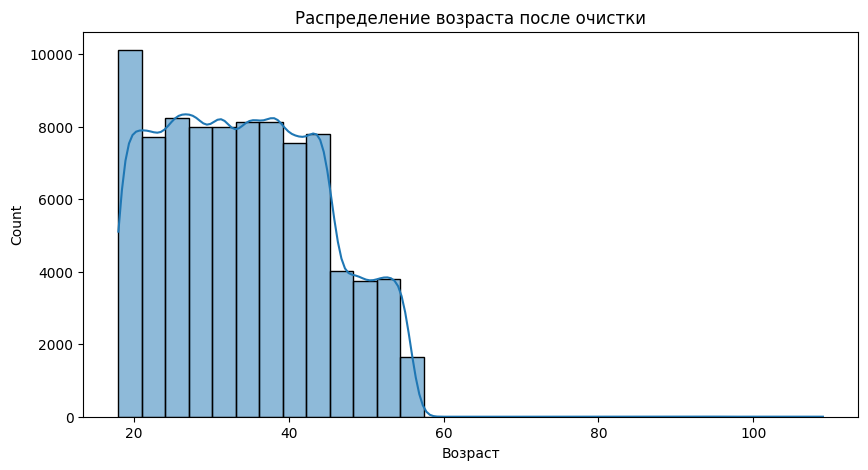

In [124]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['Age'], bins=30, kde=True)
plt.title('Распределение возраста после очистки')
plt.xlabel('Возраст')
plt.show()

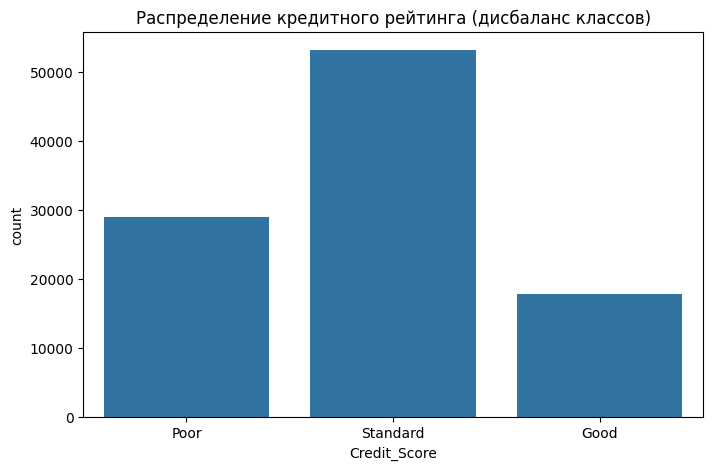

Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64


In [127]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x='Credit_Score', order=['Poor', 'Standard', 'Good'])
plt.title('Распределение кредитного рейтинга (дисбаланс классов)')
plt.show()

print(df_train['Credit_Score'].value_counts(normalize=True))

Классы кривые, Standart выделяется на фоне остальных

Это означает, что модель может запоминать наиболее частый класс, а не учиться обобщённым закономерностям.

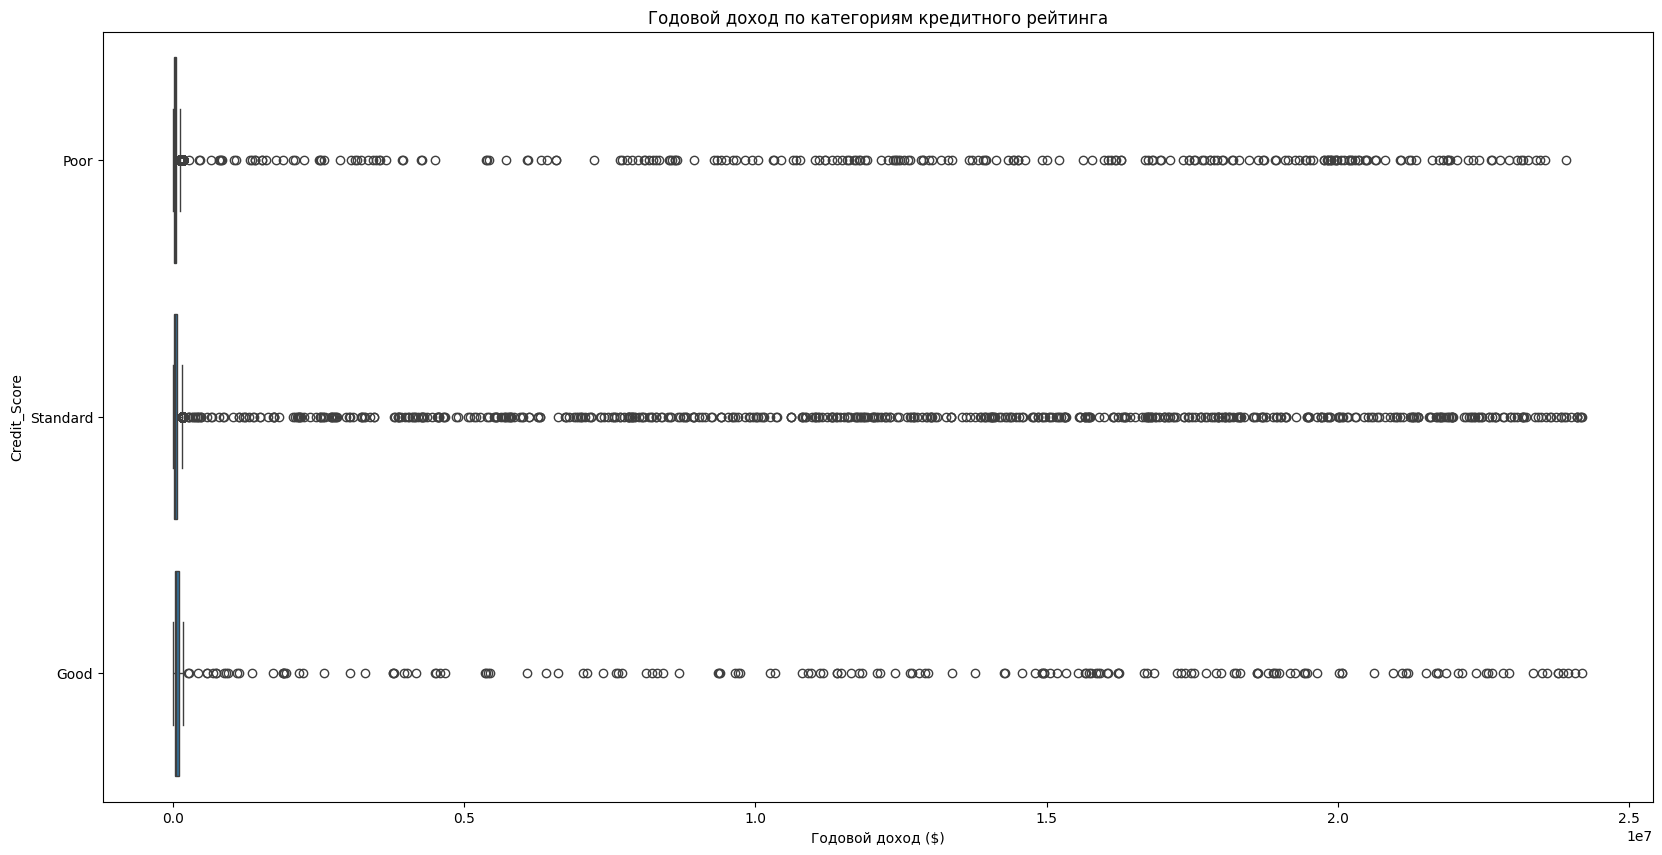

In [128]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_train, x='Annual_Income', y='Credit_Score', order=['Poor', 'Standard', 'Good'])
plt.title('Годовой доход по категориям кредитного рейтинга')
plt.xlabel('Годовой доход ($)')
plt.show()

## Baseline-model
Наконец-то Baseline и пайплайны

In [129]:
X_train = df_train.drop(columns=['Credit_Score'])
y_train = df_train['Credit_Score']
X_test = df_test

#### "Грязный" preprocessing

In [130]:
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), cat_features)
    ]
)

На самом деле я специально поставил Логистическую регрессию, знаю, что она хуже, просто так получится понаблюдать за улучшениями, и это далеко не всё.

Сейчас всё супер грязное, модель, данные, ну, понятно в общем

In [136]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Обучение
baseline_pipeline.fit(X_train, y_train)

# Предсказание (временно на train — для первого сигнала)
y_pred_baseline = baseline_pipeline.predict(X_train)

# Метрики
f1_baseline = f1_score(y_train, y_pred_baseline, average='macro')
print(f"Baseline (LogisticRegression) F1-macro: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_pred_baseline))

C:\Users\Qweeck\PycharmProjects\ml-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline (LogisticRegression) F1-macro: 0.5351

Classification Report:
              precision    recall  f1-score   support

        Good       0.51      0.34      0.40     17828
        Poor       0.64      0.43      0.52     28998
    Standard       0.61      0.78      0.68     53174

    accuracy                           0.60    100000
   macro avg       0.58      0.52      0.54    100000
weighted avg       0.60      0.60      0.59    100000



Как видим из наших метрик, Великому Предикту не понравились наши датасеты